pygame 2.0.0 (SDL 2.0.12, python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
Starting face detector...
Closing face detector...


SystemExit: 0

C:\Users\bruno\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


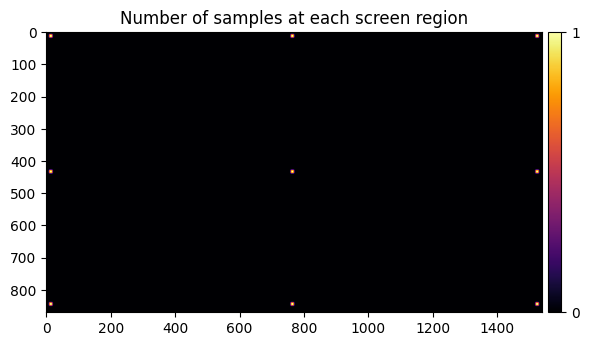

In [1]:
import os
import sys
import csv
import cv2
import random
import pygame
import numpy as np
import math

from collections import deque
from scipy.stats import beta
from pygame.locals import *
from Target import Target
from Gaze import Detector, Predictor
from Models import FullModel
from utils import (
    get_config,
    bgr_to_rgb,
    clamp_value,
    plot_region_map,
    get_calibration_zones,
    get_undersampled_region,
)

# Read config.ini file
SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")

# Setup directories
data_dirs = (
    "data/l_eye",
    "data/r_eye",
    "data/face",
    "data/face_aligned",
    "data/head_pos",
)

for d in data_dirs:
    if not os.path.exists(d):
        os.makedirs(d)

# Setup data file
data_file_path = "data/positions.csv"
data_file_exists = os.path.isfile(data_file_path)
data_file = open(data_file_path, "a", newline="")
csv_writer = csv.writer(data_file, delimiter=",")

if not data_file_exists:
    csv_writer.writerow(["id", "x", "y", "head_angle"])

# Setup pygame
pygame.init()
pygame.mouse.set_visible(0)
font_normal = pygame.font.SysFont(None, 30)
font_small = pygame.font.SysFont(None, 20)
pygame.display.set_caption("Calibrate and Collect")
screen = pygame.display.set_mode((0, 0), pygame.FULLSCREEN)
w, h = pygame.display.get_surface().get_size()
center = (w // 2, h // 2)
webcam_surface = pygame.Surface(
    (SETTINGS["image_size"] * 2, SETTINGS["image_size"] * 2)
)
calibration_zones = get_calibration_zones(w, h, SETTINGS["target_radius"])

# Create target, detector, predictor
target = Target(
    center, speed=SETTINGS["target_speed"], radius=SETTINGS["target_radius"]
)
detector = Detector(output_size=SETTINGS["image_size"])
predictor = Predictor(
    FullModel,
    model_data="trained_models/eyetracking_model.pt",
    config_file="trained_models/eyetracking_config.json",
)
screen_errors = np.load("trained_models/eyetracking_errors.npy")

# Load array of previously collected screen regions
try:
    region_map = np.load("data/region_map.npy")
except FileNotFoundError:
    region_map = np.zeros(
        (math.ceil(w / SETTINGS["map_scale"]), math.ceil(h / SETTINGS["map_scale"]))
    )

# Initialize flags and values
bg = random.choice((COLOURS["black"], COLOURS["gray"]))
bg_should_increase = True
clock = pygame.time.Clock()
ticks = 0
frame_count = 0
show_stats = False
show_webcam = False
selection_screen = True
calibrate_screen = False
calibrate_idx = 0
collect_screen = False
collect_state = 0
collect_start_region = get_undersampled_region(region_map, SETTINGS["map_scale"])
track_screen = False
track_x = deque(
    [0] * SETTINGS["avg_window_length"], maxlen=SETTINGS["avg_window_length"]
)
track_y = deque(
    [0] * SETTINGS["avg_window_length"], maxlen=SETTINGS["avg_window_length"]
)
track_error = deque(
    [0] * (SETTINGS["avg_window_length"] * 2), maxlen=SETTINGS["avg_window_length"] * 2
)
num_images = len(os.listdir("data/face"))


def save_data(
    num_images,
    l_eye,
    r_eye,
    face,
    face_align,
    head_pos,
    angle,
    targetx,
    targety,
):
    data_id = num_images + 1

    for (path, img) in zip(data_dirs, (l_eye, r_eye, face, face_align, head_pos)):
        cv2.imwrite("{}/{}.jpg".format(path, data_id), img)

    csv_writer.writerow([data_id, targetx, targety, angle])

    region_map[
        int(targetx / SETTINGS["map_scale"]), int(targety / SETTINGS["map_scale"])
    ] += 1

    return data_id


def cleanup():
    np.save("data/region_map.npy", region_map)
    plot_region_map(
        "data/region_map.png", region_map, SETTINGS["map_scale"], cmap="inferno"
    )

    data_file.close()
    detector.close()
    pygame.quit()
    sys.exit(0)


while True:
    screen.fill(bg)

    # Vary bg colour so we get variation in ocular reflection value
    bg_origin = screen.get_at((0, 0))
    if bg_origin[0] <= COLOURS["black"][0]:
        bg_should_increase = True
    elif bg_origin[0] >= COLOURS["gray"][0]:
        bg_should_increase = False

    if bg_should_increase:
        bg = (bg_origin[0] + 1, bg_origin[1] + 1, bg_origin[2] + 1, bg_origin[3])
    else:
        bg = (bg_origin[0] - 1, bg_origin[1] - 1, bg_origin[2] - 1, bg_origin[3])

    # Get current frame from the detector
    frame_count += 1
    frame, l_eye, r_eye, face, face_align, head_pos, angle = detector.get_frame()

    if show_stats:
        if region_map.max() == 0:
            region_map_3d = region_map
        else:
            region_map_3d = region_map * (255.0 / region_map.max())
        region_map_3d = np.broadcast_to(
            region_map_3d[..., None], region_map_3d.shape + (3,)
        )

        region_surface = pygame.surfarray.make_surface(region_map_3d)
        region_surface = pygame.transform.scale(region_surface, (w, h))
        screen.blit(region_surface, (0, 0))

        num_images_text = font_normal.render(
            "# of images: {}".format(num_images),
            True,
            COLOURS["white"],
        )

        img_dims_text = font_normal.render(
            "Image dimensions: {}x{}px".format(
                SETTINGS["image_size"], SETTINGS["image_size"]
            ),
            True,
            COLOURS["white"],
        )

        coverage_text = font_normal.render(
            "Coverage: {}%".format(
                round(np.count_nonzero(region_map > 0) / region_map.size * 100, 2)
            ),
            True,
            COLOURS["white"],
        )

        text_height = coverage_text.get_height()
        screen.blit(coverage_text, (10, h - text_height * 4))
        screen.blit(num_images_text, (10, h - text_height * 3))
        screen.blit(img_dims_text, (10, h - text_height * 2))

    if show_webcam:
        screen.blit(webcam_surface, (0, SETTINGS["target_radius"] * 2))
        pygame.surfarray.blit_array(
            webcam_surface,
            bgr_to_rgb(
                np.rot90(
                    np.vstack(
                        (
                            np.hstack(
                                (
                                    np.repeat(head_pos[:, :, np.newaxis], 3, axis=2),
                                    face_align,
                                )
                            ),
                            np.hstack((l_eye, r_eye)),
                        )
                    ),
                    1,
                )
            ),
        )

        angle_text = font_small.render(
            "{} deg".format(round(angle, 1)), True, COLOURS["green"]
        )
        fps_text = font_small.render(
            "{} fps".format(int(clock.get_fps())), True, COLOURS["green"]
        )

        webcam_surface.blit(angle_text, (2, 0))
        webcam_surface.blit(
            fps_text, (2, webcam_surface.get_height() - fps_text.get_height())
        )

    # Selection screen
    if selection_screen:
        text1 = font_normal.render(
            "(1) Calibrate | (2) Collect | (3) Track", True, COLOURS["white"]
        )
        text2 = font_normal.render(
            "(c) Toggle camera | (s) Show stats | (esc) Quit", True, COLOURS["white"]
        )
        screen.blit(text1, (10, h * 0.3))
        screen.blit(text2, (10, h * 0.6))

        for event in pygame.event.get():
            if event.type == pygame.VIDEORESIZE:
                w, h = pygame.display.get_surface().get_size()
                calibration_zones = get_calibration_zones(
                    w, h, SETTINGS["target_radius"]
                )
            elif event.type == KEYDOWN and event.key == K_ESCAPE:
                cleanup()
            elif event.type == KEYDOWN and event.key == K_c:
                show_webcam = not show_webcam
            elif event.type == KEYDOWN and event.key == K_s:
                show_stats = not show_stats
            elif event.type == KEYDOWN and event.key == K_1:
                selection_screen = False
                calibrate_screen = True
                target.moving = False
                target.color = COLOURS["red"]
            elif event.type == KEYDOWN and event.key == K_2:
                selection_screen = False
                collect_screen = True
                target.color = COLOURS["green"]
            elif event.type == KEYDOWN and event.key == K_3:
                selection_screen = False
                track_screen = True
                target.color = COLOURS["red"]

    # Calibration screen
    if calibrate_screen:
        for event in pygame.event.get():
            if event.type == pygame.VIDEORESIZE:
                w, h = pygame.display.get_surface().get_size()
                calibration_zones = get_calibration_zones(
                    w, h, SETTINGS["target_radius"]
                )
            elif event.type == KEYDOWN and event.key == K_ESCAPE:
                cleanup()
            elif event.type == KEYDOWN and event.key == K_c:
                show_webcam = not show_webcam
            elif event.type == KEYDOWN and event.key == K_s:
                show_stats = not show_stats
            elif event.type == KEYDOWN and event.key == K_SPACE:
                if calibrate_idx < len(calibration_zones):
                    num_images = save_data(
                        num_images,
                        l_eye,
                        r_eye,
                        face,
                        face_align,
                        head_pos,
                        angle,
                        target.x,
                        target.y,
                    )
                calibrate_idx += 1

        if calibrate_idx < len(calibration_zones):
            target.x, target.y = calibration_zones[calibrate_idx]
            target.render(screen)
        elif calibrate_idx == len(calibration_zones):
            screen.fill(COLOURS["black"])
            text = font_normal.render("Done", True, COLOURS["white"])
            screen.blit(text, text.get_rect(center=screen.get_rect().center))
        elif calibrate_idx > len(calibration_zones):
            calibrate_idx = 0
            selection_screen = True
            calibrate_screen = False

    # Data collection screen
    if collect_screen:
        for event in pygame.event.get():
            if event.type == pygame.VIDEORESIZE:
                w, h = pygame.display.get_surface().get_size()
                calibration_zones = get_calibration_zones(
                    w, h, SETTINGS["target_radius"]
                )
            elif event.type == KEYDOWN and event.key == K_ESCAPE:
                cleanup()
            elif event.type == KEYDOWN and event.key == K_c:
                show_webcam = not show_webcam
            elif event.type == KEYDOWN and event.key == K_s:
                show_stats = not show_stats
            elif event.type == KEYDOWN and event.key == K_SPACE:
                collect_state += 1
                target.moving = False

        if collect_state == 0:
            target.x = collect_start_region[0]
            target.y = collect_start_region[1]
            target.render(screen)
        elif collect_state == 1:
            if not target.moving:
                if SETTINGS["only_edges"]:
                    new_x = random.choice([0, w])
                    new_y = random.choice([0, h])
                    center = (new_x, new_y)
                elif SETTINGS["focus_edges"]:
                    new_x = (
                        beta.rvs(SETTINGS["beta_a"], SETTINGS["beta_b"], size=1) * w
                    )[0]
                    new_y = (
                        beta.rvs(SETTINGS["beta_a"], SETTINGS["beta_b"], size=1) * h
                    )[0]
                    center = (new_x, new_y)
                else:
                    center = get_undersampled_region(region_map, SETTINGS["map_scale"])

            if frame_count % SETTINGS["skip_frames"] == 0:
                frame_count = 0
                num_images = save_data(
                    num_images,
                    l_eye,
                    r_eye,
                    face,
                    face_align,
                    head_pos,
                    angle,
                    target.x,
                    target.y,
                )

            target.move(center, ticks)
            target.render(screen)
        elif collect_state == 2:
            screen.fill(COLOURS["black"])
            text = font_normal.render("Done", True, COLOURS["white"])
            screen.blit(text, text.get_rect(center=screen.get_rect().center))
        elif collect_state > 2:
            collect_state = 0
            selection_screen = True
            collect_screen = False

    # Track screen
    if track_screen:
        for event in pygame.event.get():
            if event.type == pygame.VIDEORESIZE:
                w, h = pygame.display.get_surface().get_size()
                calibration_zones = get_calibration_zones(
                    w, h, SETTINGS["target_radius"]
                )
            elif event.type == KEYDOWN and event.key == K_ESCAPE:
                cleanup()
            elif event.type == KEYDOWN and event.key == K_c:
                show_webcam = not show_webcam
            elif event.type == KEYDOWN and event.key == K_s:
                show_stats = not show_stats
            elif event.type == KEYDOWN and event.key == K_SPACE:
                selection_screen = True
                track_screen = False

        x_hat, y_hat = predictor.predict(face, l_eye, r_eye, head_pos, head_angle=angle)
        track_x.append(x_hat)
        track_y.append(y_hat)

        x_hat_clamp = clamp_value(x_hat, w)
        y_hat_clamp = clamp_value(y_hat, h)
        error = screen_errors[int(x_hat_clamp) - 1][int(y_hat_clamp) - 1]
        track_error.append(error * 0.75)

        weights = np.arange(1, SETTINGS["avg_window_length"] + 1)
        weights_error = np.arange(1, (SETTINGS["avg_window_length"] * 2) + 1)

        target.x = np.average(track_x, weights=weights)
        target.y = np.average(track_y, weights=weights)
        target.radius = np.average(track_error, weights=weights_error)
        target.render(screen)

    ticks = clock.tick(SETTINGS["record_frame_rate"])
    pygame.display.update()